In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import seaborn as sns
from PIL import Image
import os

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [ ]:
# Define data transformations with additional augmentation
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),  # Randomly rotate images by up to 15 degrees
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Randomly translate images by up to 10% in both directions
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


# Load the dataset
dataset_path = '/kaggle/input/rice-plant-diseases-dataset/rice leaf diseases dataset'
full_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Split dataset into train and validation sets
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

trainloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
valloader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

# Get the classes
classes = full_dataset.classes
num_classes = len(classes)
print(f"Classes: {classes}")


Classes: ['Bacterialblight', 'Brownspot', 'Leafsmut']


In [ ]:
class QRNNLayer(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, dropout=0.5):
        super(QRNNLayer, self).__init__()
        self.hidden_dim = hidden_dim

        self.conv_z = nn.Conv1d(input_dim, hidden_dim, kernel_size, padding=kernel_size-1)
        self.conv_f = nn.Conv1d(input_dim, hidden_dim, kernel_size, padding=kernel_size-1)
        self.conv_o = nn.Conv1d(input_dim, hidden_dim, kernel_size, padding=kernel_size-1)

        self.dropout = nn.Dropout(dropout)
        self.hidden = None

    def forward(self, x):
        batch_size, time_steps, _ = x.size()
        if self.hidden is None or self.hidden.size(0) != batch_size:
            self.hidden = torch.zeros(batch_size, self.hidden_dim).to(x.device)

        x = x.permute(0, 2, 1)  # Shape (batch_size, input_dim, time_steps)
        z = self.conv_z(x)[:, :, :-self.conv_z.padding[0]]
        f = torch.sigmoid(self.conv_f(x)[:, :, :-self.conv_f.padding[0]])
        o = torch.sigmoid(self.conv_o(x)[:, :, :-self.conv_o.padding[0]])
        f = self.dropout(f)

        z = z.permute(0, 2, 1)  # Shape (batch_size, time_steps, hidden_dim)
        f = f.permute(0, 2, 1)
        o = o.permute(0, 2, 1)

        h = []
        for t in range(z.size(1)):
            self.hidden = f[:, t, :] * self.hidden + (1 - f[:, t, :]) * z[:, t, :]
            h_t = o[:, t, :] * self.hidden
            h.append(h_t.unsqueeze(1))

        h = torch.cat(h, dim=1)
        return h

    def reset_hidden_state(self):
        self.hidden = None

In [ ]:
class QRNNImageClassifier(nn.Module):
    def __init__(self, num_classes=3):
        super(QRNNImageClassifier, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.qrnn = QRNNLayer(256, 256, kernel_size=2)
        self.classifier = nn.Sequential(
            nn.Linear(256, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)  # x should have shape [batch_size, 256, height, width]
        x = x.view(x.size(0), x.size(1), -1).permute(0, 2, 1)  # Reshape x to [batch_size, height*width, 256]
        self.qrnn.reset_hidden_state()  # Reset hidden state before forward pass
        x = self.qrnn(x)  # Output from QRNN should be [batch_size, height*width, 256]
        x = x.mean(dim=1)  # Global average pooling over the time dimension
        x = self.classifier(x)  # x should have shape [batch_size, num_classes]
        return x


In [ ]:
# Instantiate the model
net = QRNNImageClassifier(num_classes=3).to(device)


In [ ]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)


In [ ]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
def train(net, trainloader, criterion, optimizer, epoch):
    net.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if i % 100 == 99:
            print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 100:.3f}")
            running_loss = 0.0

    train_loss = running_loss / len(trainloader)
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    print(f"Epoch {epoch + 1} - Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")

# Evaluation function
def evaluate(net, valloader):
    net.eval()
    correct = 0
    total = 0
    val_loss = 0.0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for data in valloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    val_loss /= len(valloader)
    val_accuracy = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
    return all_labels, all_preds

# Training and evaluating the model
num_epochs = 50
for epoch in range(num_epochs):
    train(net, trainloader, criterion, optimizer, epoch)
    labels, preds = evaluate(net, valloader)


[1, 100] loss: 0.677
Epoch 1 - Train Loss: 0.1095, Train Accuracy: 73.13%
Validation Loss: 0.5719, Validation Accuracy: 75.88%
[2, 100] loss: 0.586
Epoch 2 - Train Loss: 0.1009, Train Accuracy: 78.89%
Validation Loss: 0.9527, Validation Accuracy: 65.64%
[3, 100] loss: 0.469
Epoch 3 - Train Loss: 0.0717, Train Accuracy: 81.75%
Validation Loss: 0.3772, Validation Accuracy: 87.83%
[4, 100] loss: 0.385
Epoch 4 - Train Loss: 0.0845, Train Accuracy: 84.97%
Validation Loss: 0.4526, Validation Accuracy: 81.75%
[5, 100] loss: 0.354
Epoch 5 - Train Loss: 0.0602, Train Accuracy: 86.87%
Validation Loss: 0.2686, Validation Accuracy: 90.82%
[6, 100] loss: 0.279
Epoch 6 - Train Loss: 0.0503, Train Accuracy: 89.83%
Validation Loss: 0.4324, Validation Accuracy: 82.71%
[7, 100] loss: 0.255
Epoch 7 - Train Loss: 0.0657, Train Accuracy: 91.19%
Validation Loss: 0.2801, Validation Accuracy: 89.75%
[8, 100] loss: 0.282
Epoch 8 - Train Loss: 0.0522, Train Accuracy: 90.29%
Validation Loss: 0.1984, Validation A

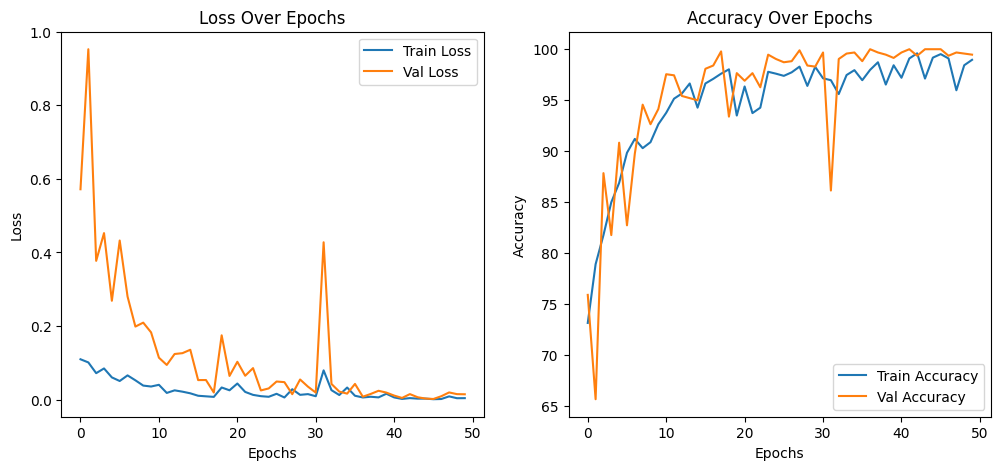

In [ ]:
# Plot accuracy and loss graphs
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.show()


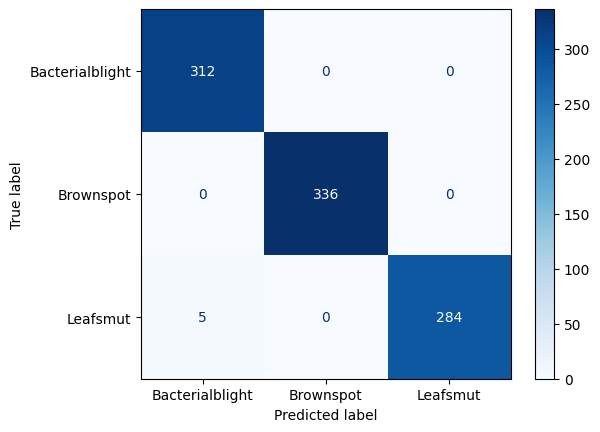

In [ ]:
# Confusion Matrix
cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

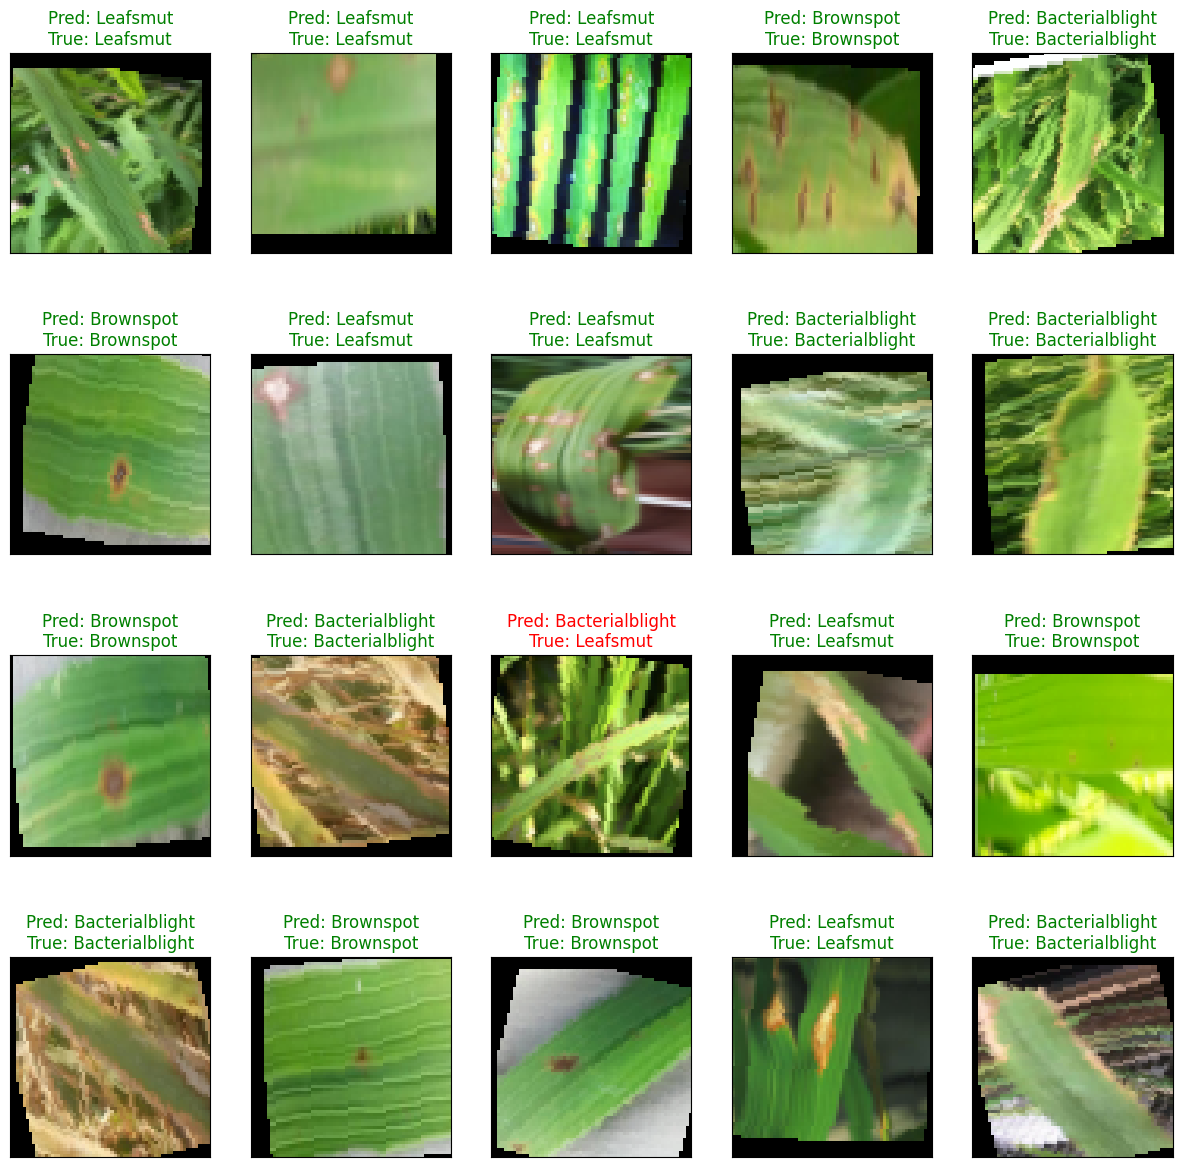

In [ ]:
def predict_sample(net, dataloader, num_images=20):
    net.eval()
    dataiter = iter(dataloader)
    images, labels = next(dataiter)
    images, labels = images.to(device), labels.to(device)

    outputs = net(images)
    _, predicted = torch.max(outputs, 1)

    # Display images and predictions
    fig = plt.figure(figsize=(15, 15))  # Adjusted figure size for more images
    for idx in range(num_images):
        ax = fig.add_subplot(4, 5, idx + 1, xticks=[], yticks=[])  # 4 rows, 5 columns
        img = images[idx].cpu().numpy().transpose((1, 2, 0))
        img = np.clip(img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]), 0, 1)
        ax.imshow(img)
        ax.set_title(f"Pred: {classes[predicted[idx]]}\nTrue: {classes[labels[idx]]}", color=("green" if predicted[idx] == labels[idx] else "red"))
    plt.show()

# Predict sample
predict_sample(net, valloader, num_images=20)
